# KE5018 Time Series Forecasting

## Load libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Load time series data

In [2]:
ts_df = pd.read_excel('data/ActualRatings_weeklyGRP.xls', sheet_name=1)

In [3]:
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
GRPRatingsDate    92 non-null object
GRP               92 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [4]:
ts_df.head()

,GRPRatingsDate,GRP
0,17-Jun-2007 (25),243.60
1,24-Jun-2007 (26),263.19
2,01-Jul-2007 (27),269.89
3,08-Jul-2007 (28),252.88
4,15-Jul-2007 (29),303.46


In [5]:
ts_df.tail()

,GRPRatingsDate,GRP
87,15-Feb-2009 (8),204.20
88,22-Feb-2009 (9),200.61
89,01-Mar-2009 (10),208.56
90,08-Mar-2009 (11),191.74
91,15-Mar-2009 (12),222.07


## Transform the Data for Analysis

In [6]:
# Create a date/time column for week.
ts_df['weekly_date'] = pd.date_range('17/6/2007', '15/3/2009', freq='W')

In [7]:
ts_df.head()

,GRPRatingsDate,GRP,weekly_date
0,17-Jun-2007 (25),243.60,2007-06-17
1,24-Jun-2007 (26),263.19,2007-06-24
2,01-Jul-2007 (27),269.89,2007-07-01
3,08-Jul-2007 (28),252.88,2007-07-08
4,15-Jul-2007 (29),303.46,2007-07-15


In [8]:
# Index the data frame by week. Keep the original index as a running number by week. 
ts_df.reset_index(inplace=True)
ts_df.set_index('weekly_date', inplace=True)

In [9]:
ts_df.head()

,index,GRPRatingsDate,GRP
weekly_date,,,
2007-06-17,0,17-Jun-2007 (25),243.60
2007-06-24,1,24-Jun-2007 (26),263.19
2007-07-01,2,01-Jul-2007 (27),269.89
2007-07-08,3,08-Jul-2007 (28),252.88
2007-07-15,4,15-Jul-2007 (29),303.46


In [10]:
ts_df.rename(columns={'index':'week'}, inplace=True)

In [11]:
ts_df.describe()

,week,GRP
count,92.00000,92.000000
mean,45.50000,240.829783
std,26.70206,38.680913
min,0.00000,170.740000
25%,22.75000,209.980000
50%,45.50000,231.490000
75%,68.25000,272.927500
max,91.00000,327.220000


In [12]:
# Save the data frame to file.
ts_df.to_csv('data/transformedRatings.csv')

## Show the Time Series Data

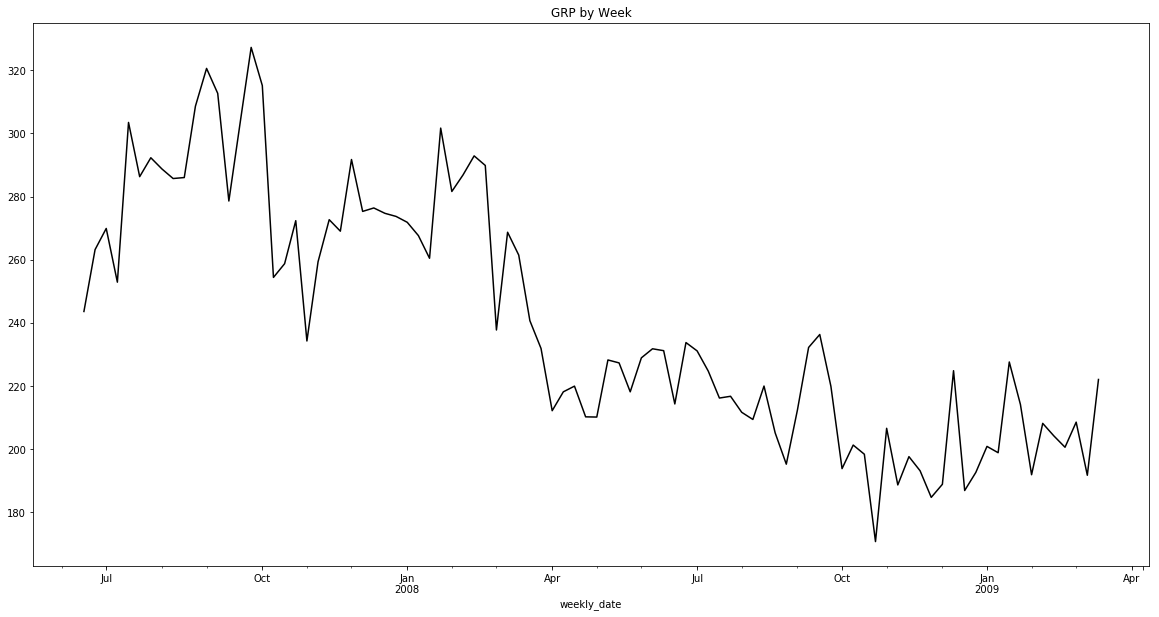

In [13]:
ts_df['GRP'].plot(figsize=(20, 10), title='GRP by Week', color='black')

As the plot for the time series data show a decreasing seasonal variation, we can try a Box-Cox transformation to convert the changing variation to a constant variation.

In [14]:
# Lambda was found from the boxcox function prior to this.
BOXCOX_LAMBDA = -0.5677106
ts_df['GRP_boxcox'] = boxcox(ts_df['GRP'], lmbda=BOXCOX_LAMBDA)
ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792


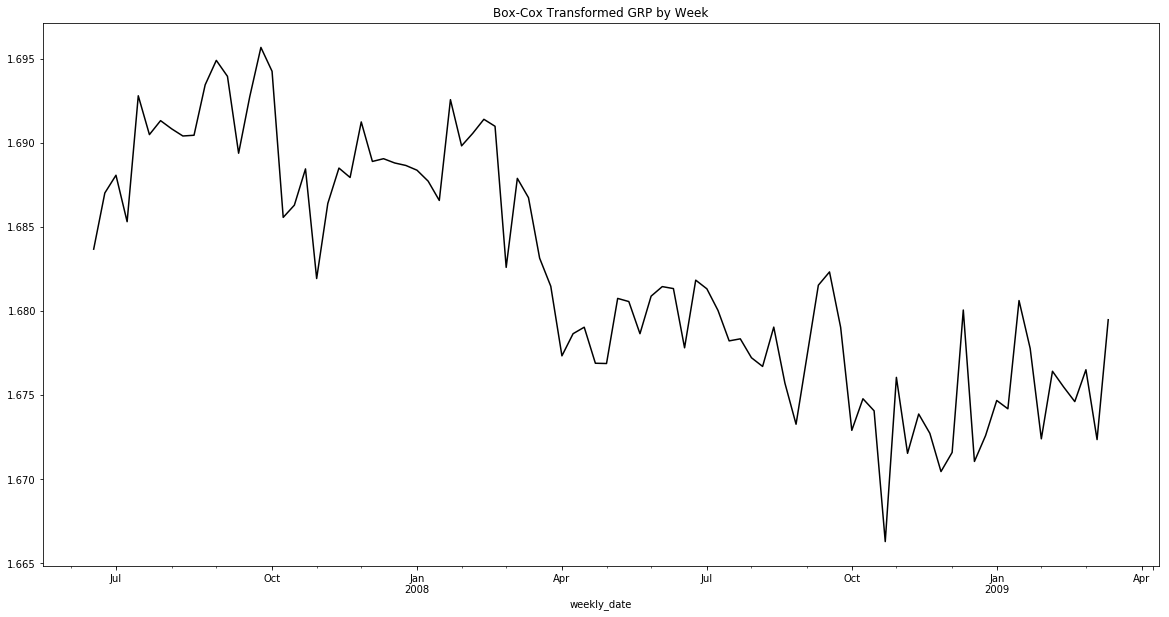

In [15]:
ts_df['GRP_boxcox'].plot(figsize=(20, 10), title='Box-Cox Transformed GRP by Week', color='black')

The possible seasonal variation is reduced after the Box-Cox transformation.

## Prepare the Train / Test Datasets

In [16]:
train_ts_df = ts_df.loc['17/6/2007':'17/6/2008']
test_ts_df = ts_df.loc['18/6/2008':]

In [17]:
train_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2007-06-17 to 2008-06-15
Data columns (total 4 columns):
week              53 non-null int64
GRPRatingsDate    53 non-null object
GRP               53 non-null float64
GRP_boxcox        53 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.1+ KB


In [18]:
test_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2008-06-22 to 2009-03-15
Data columns (total 4 columns):
week              39 non-null int64
GRPRatingsDate    39 non-null object
GRP               39 non-null float64
GRP_boxcox        39 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ KB


In [19]:
train_ts_df['GRP'].values

array([ 243.6 ,  263.19,  269.89,  252.88,  303.46,  286.29,  292.28,
        288.72,  285.7 ,  286.01,  308.59,  320.57,  312.67,  278.58,
        303.06,  327.22,  315.14,  254.39,  258.73,  272.35,  234.26,
        259.35,  272.67,  269.03,  291.72,  275.29,  276.38,  274.68,
        273.7 ,  271.84,  267.63,  260.45,  301.67,  281.6 ,  286.82,
        292.87,  289.84,  237.74,  268.69,  261.46,  240.68,  231.89,
        212.18,  218.16,  219.96,  210.24,  210.17,  228.25,  227.32,
        218.16,  228.92,  231.79,  231.19])

In [20]:
# Save train, test datasets to file.
train_ts_df.to_csv('data/transformedTrainRatings.csv')
test_ts_df.to_csv('data/transformedTestRatings.csv')

## Linear Regression Model

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP_boxcox'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Training Results

In [22]:
lin_reg_train_pred = inv_boxcox(lin_reg.predict(train_ts_df['week'].values.reshape(-1, 1)), BOXCOX_LAMBDA)
lin_reg_train_pred[:10]

array([ 301.80661184,  300.14299737,  298.49371418,  296.85859465,
        295.2374736 ,  293.6301883 ,  292.03657839,  290.45648588,
        288.88975506,  287.33623249])

In [23]:
lin_reg_train_mse = mean_squared_error(train_ts_df['GRP'].values, lin_reg_train_pred)
lin_reg_train_mse

In [24]:
lin_reg_train_rmse = np.sqrt(lin_reg_train_mse)
lin_reg_train_rmse

In [25]:
lin_reg_r2 = r2_score(train_ts_df['GRP'].values, lin_reg_train_pred)
lin_reg_r2

0.38005858772868173

In [26]:
lin_reg_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - lin_reg_train_pred) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
lin_reg_train_mape

7.1807174125844586

### Test Results

In [27]:
lin_reg_test_pred = inv_boxcox(lin_reg.predict(test_ts_df['week'].values.reshape(-1, 1)), BOXCOX_LAMBDA)
lin_reg_test_pred[:10]

array([ 230.07272694,  228.98493739,  227.90518914,  226.83340144,
        225.76949455,  224.71338975,  223.66500931,  222.62427649,
        221.59111549,  220.56545147])

In [28]:
lin_reg_test_mse = mean_squared_error(test_ts_df['GRP'].values, lin_reg_test_pred)
lin_reg_test_rmse = np.sqrt(lin_reg_test_mse)
lin_reg_test_mape = np.sum(np.abs(test_ts_df['GRP'].values - lin_reg_test_pred) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100
print('mse = %f\nrmse = %f\nmape = %f'% (lin_reg_test_mse, lin_reg_test_rmse, lin_reg_test_mape))

mse = 237.068669
rmse = 15.397034
mape = 6.316136


In [29]:
results_list = []
results_list.append([lin_reg_train_mse, lin_reg_train_rmse, lin_reg_train_mape, lin_reg_r2, lin_reg_test_mse, lin_reg_test_rmse, lin_reg_test_mape])
results_list

[[583.97119424801372,
  24.165495944590372,
  7.1807174125844586,
  0.38005858772868173,
  237.06866921261994,
  15.397034429156152,
  6.3161360879461865]]

### Plot the Predicted Results

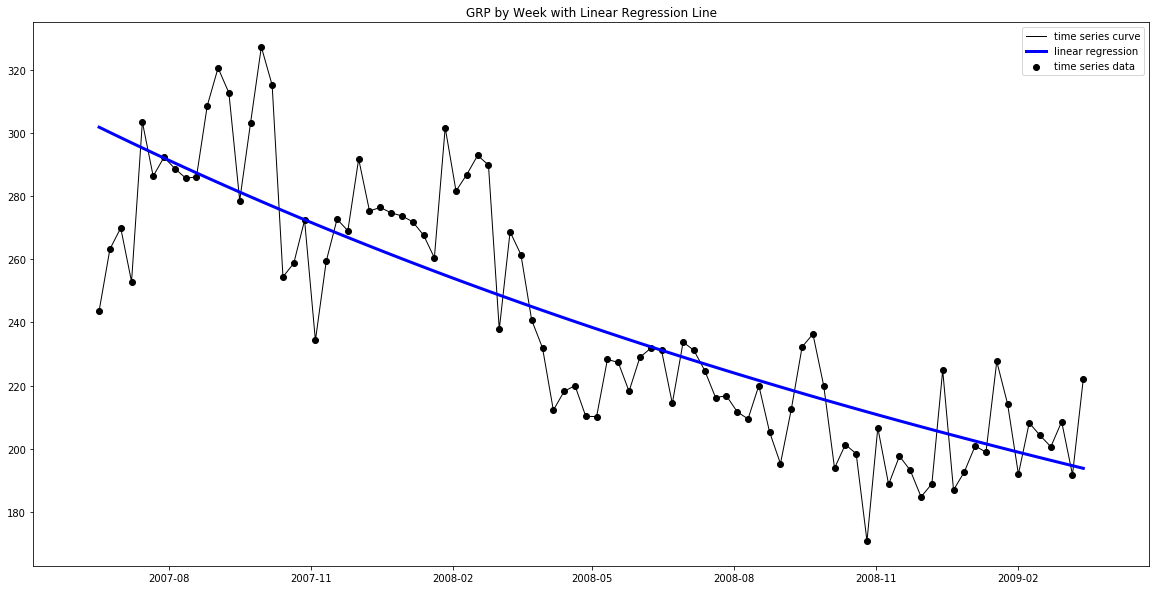

In [30]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Linear Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([lin_reg_train_pred, lin_reg_test_pred]), color='blue', linewidth=3, label='linear regression')
plt.legend()
plt.show()

### Analysis of Residuals

In [31]:
residuals = train_ts_df['GRP'].values - lin_reg_train_pred
residuals

In [32]:
poly_reg_res = Pipeline([('poly', PolynomialFeatures(degree=3)),
                         ('linear', LinearRegression(fit_intercept=False))])
poly_reg_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
poly_reg_res_pred = poly_reg_res.predict(train_ts_df['week'].values.reshape(-1, 1))

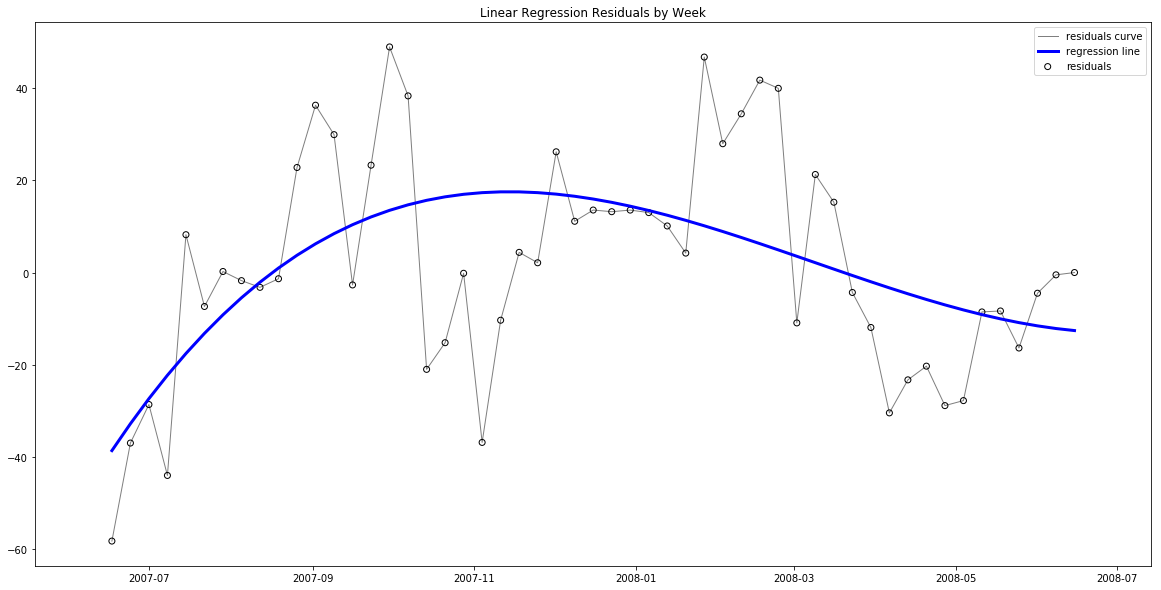

In [33]:
plt.figure(figsize=(20, 10))
plt.title('Linear Regression Residuals by Week')
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, poly_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

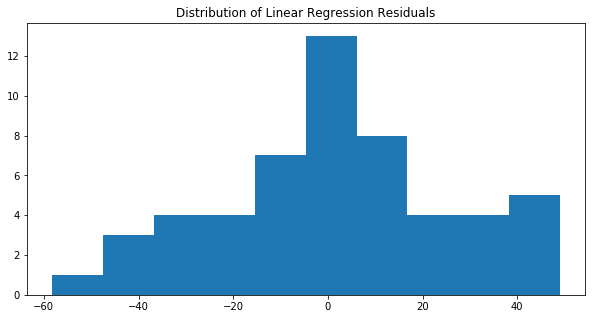

In [34]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of Linear Regression Residuals')
plt.hist(residuals)
plt.show()

In [35]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,19.797571,8.609203e-06
1,2,29.362615,4.207161e-07
2,3,37.744262,3.201721e-08
3,4,40.387239,3.599379e-08
4,5,40.773881,1.042322e-07
5,6,40.785578,3.191368e-07
6,7,41.440721,6.661953e-07
7,8,42.469331,1.105474e-06
8,9,45.273428,8.211914e-07
9,10,49.193688,3.753480e-07


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


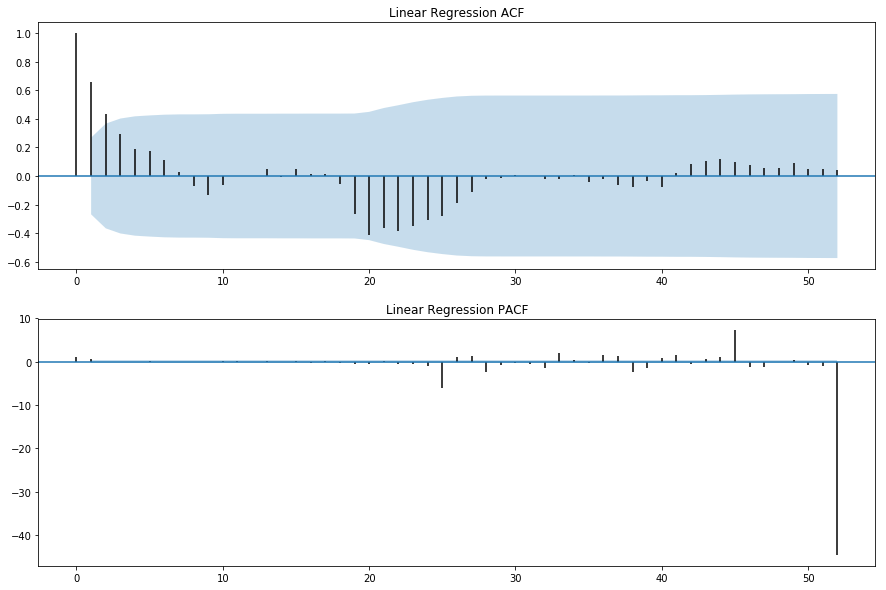

In [111]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, title='Linear Regression ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, title='Linear Regression PACF', marker=None)
plt.show()

The residuals are not white noise. The linear model is not a suitable functional form for the time series data.

## Polynomial Regression Model

In [37]:
poly_reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                         ('linear', LinearRegression(fit_intercept=False))])
poly_reg.fit(train_ts_df['week'].values.reshape(-1, 1), train_ts_df['GRP'])
poly_reg_train_pred = poly_reg.predict(train_ts_df['week'].values.reshape(-1, 1))

### Training Results

In [38]:
poly_reg_train_mse = mean_squared_error(train_ts_df['GRP'].values, poly_reg_train_pred)
poly_reg_train_rmse = np.sqrt(poly_reg_train_mse)
print('mse = %f\nrmse = %f' % (poly_reg_train_mse, poly_reg_train_rmse))

mse = 392.078675
rmse = 19.800977


In [39]:
poly_reg_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - poly_reg_train_pred) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
poly_reg_train_mape

5.920484423354174

In [40]:
poly_reg_r2 = r2_score(train_ts_df['GRP'].values, poly_reg_train_pred)
poly_reg_r2

0.58377089546071503

### Test Results

In [41]:
poly_reg_test_pred = poly_reg.predict(test_ts_df['week'].values.reshape(-1, 1))
poly_reg_test_mse = mean_squared_error(test_ts_df['GRP'].values, poly_reg_test_pred)
poly_reg_test_rmse = np.sqrt(poly_reg_test_mse)
print('mse = %f\nrmse = %f' % (poly_reg_test_mse, poly_reg_test_rmse))

mse = 5331.790540
rmse = 73.019111


In [42]:
poly_reg_test_mape = np.sum(np.abs(test_ts_df['GRP'].values - poly_reg_test_pred) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100
poly_reg_test_mape

26.619380477277272

In [43]:
results_list.append([poly_reg_train_mse, poly_reg_train_rmse, poly_reg_train_mape, poly_reg_r2, poly_reg_test_mse, poly_reg_test_rmse, poly_reg_test_mape])
results_list

[[583.97119424801372,
  24.165495944590372,
  7.1807174125844586,
  0.38005858772868173,
  237.06866921261994,
  15.397034429156152,
  6.3161360879461865],
 [392.07867460902827,
  19.800976607456217,
  5.920484423354174,
  0.58377089546071503,
  5331.7905399494612,
  73.019110785803605,
  26.619380477277272]]

### Plot the Predicted Results

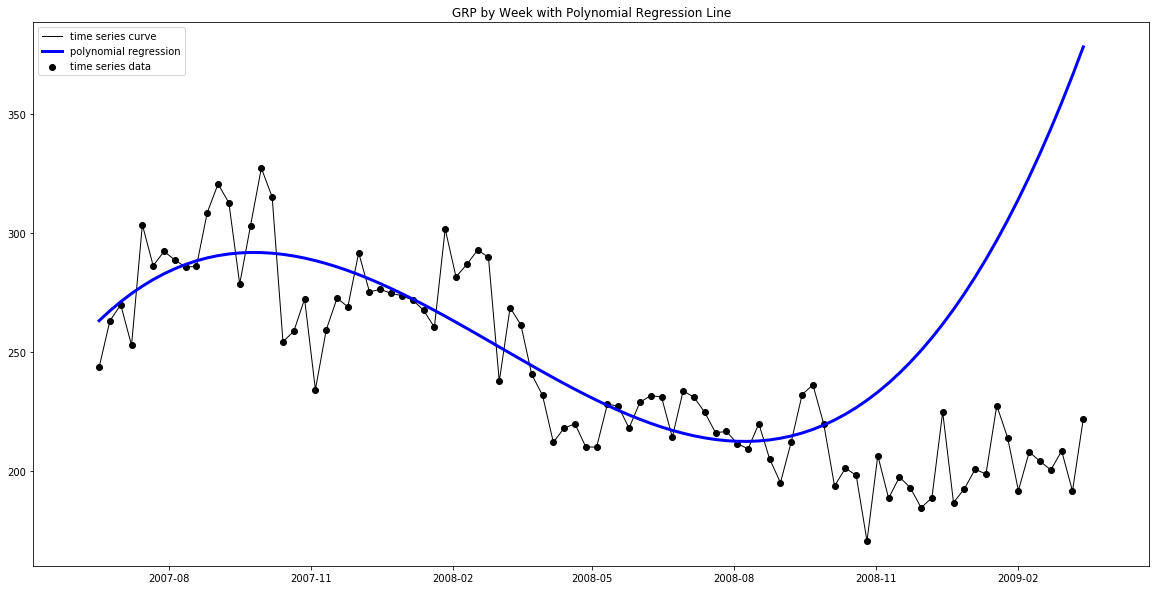

In [44]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Polynomial Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([poly_reg_train_pred, poly_reg_test_pred]), color='blue', linewidth=3, label='polynomial regression')
plt.legend()
plt.show()

The polynomial regression model generalises poorly to the test data. Higher degree polynomial models perform worse.

### Analysis of Residuals

In [45]:
residuals = train_ts_df['GRP'].values - poly_reg_train_pred
poly_reg_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=4)),
        ('linear', LinearRegression(fit_intercept=False))])
poly_reg_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
poly_reg_res_pred = poly_reg_res.predict(train_ts_df['week'].values.reshape(-1, 1))

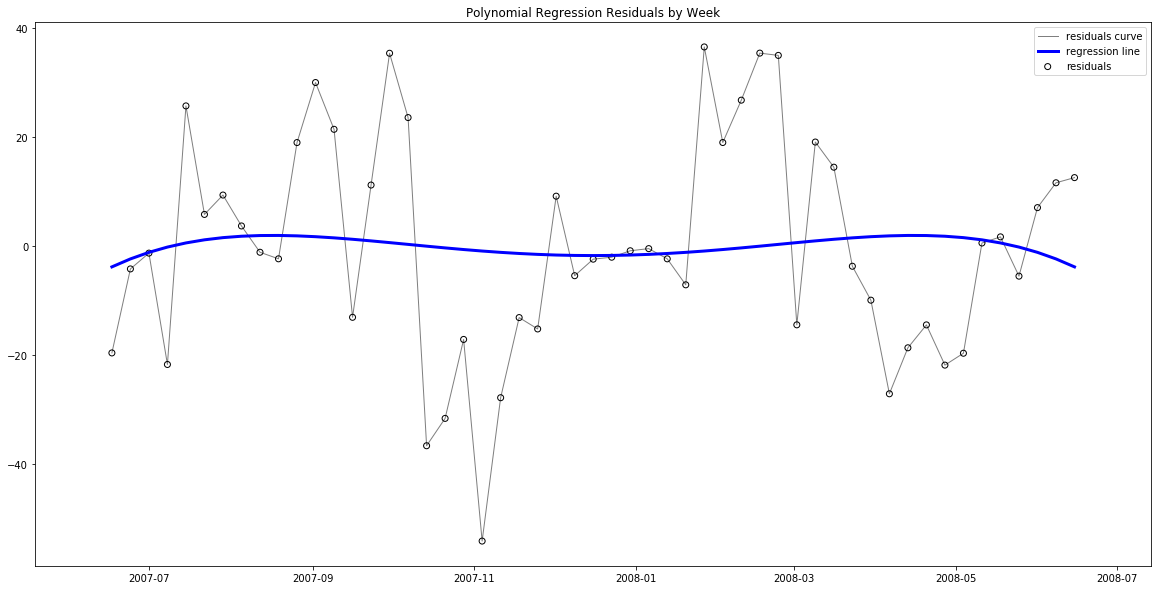

In [46]:
plt.figure(figsize=(20, 10))
plt.title('Polynomial Regression Residuals by Week')
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, poly_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

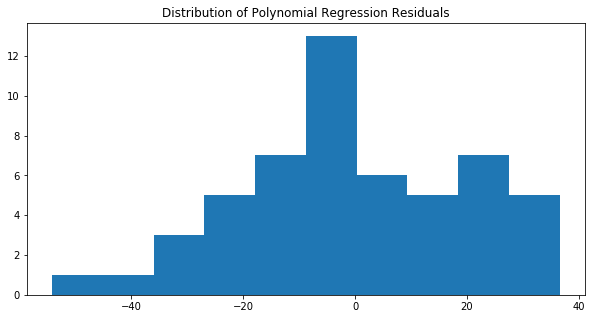

In [47]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of Polynomial Regression Residuals')
plt.hist(residuals)
plt.show()

In [48]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,13.072192,0.000300
1,2,17.074700,0.000196
2,3,21.459990,0.000084
3,4,22.511836,0.000158
4,5,22.711726,0.000383
5,6,24.207655,0.000478
6,7,27.905286,0.000229
7,8,31.134352,0.000133
8,9,36.482505,0.000033
9,10,41.580664,0.000009


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


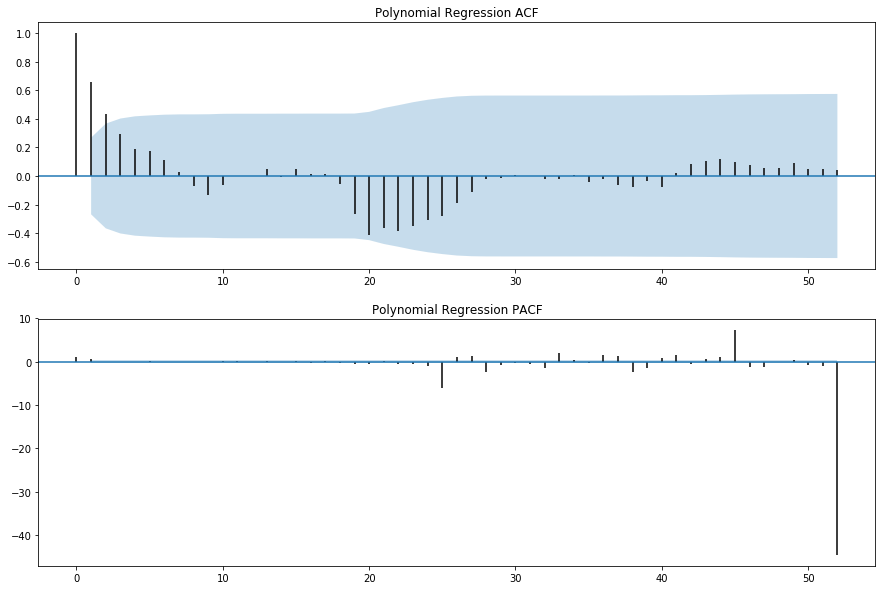

In [113]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, title='Polynomial Regression ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, title='Polynomial Regression PACF', marker=None)
plt.show()

The residuals exhibits autocorrelation at lag 1. There is variance not fully accounted for by the model.

## Dummy Variable Regression

### Create the Dummy Variables for Month

In [50]:
ts_df['month'] = ts_df.index.month

In [51]:
pd.get_dummies(ts_df['month']).head()

,1,2,3,4,5,6,7,8,9,10,11,12
weekly_date,,,,,,,,,,,,
2007-06-17,0,0,0,0,0,1,0,0,0,0,0,0
2007-06-24,0,0,0,0,0,1,0,0,0,0,0,0
2007-07-01,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-08,0,0,0,0,0,0,1,0,0,0,0,0
2007-07-15,0,0,0,0,0,0,1,0,0,0,0,0


In [52]:
ts_dummy_df = pd.concat([pd.get_dummies(ts_df['month']), ts_df.drop(labels='month', axis=1)], axis=1)

In [53]:
ts_dummy_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,,,,,,,,,,,,,
2007-06-17,0,0,0,0,0,1,0,0,0,0,0,0,0,17-Jun-2007 (25),243.60,1.683670
2007-06-24,0,0,0,0,0,1,0,0,0,0,0,0,1,24-Jun-2007 (26),263.19,1.687012
2007-07-01,0,0,0,0,0,0,1,0,0,0,0,0,2,01-Jul-2007 (27),269.89,1.688067
2007-07-08,0,0,0,0,0,0,1,0,0,0,0,0,3,08-Jul-2007 (28),252.88,1.685303
2007-07-15,0,0,0,0,0,0,1,0,0,0,0,0,4,15-Jul-2007 (29),303.46,1.692792


In [54]:
# Split into training and test datasets.
train_ts_dummy_df = ts_dummy_df.loc['17/6/2007':'17/6/2008']
test_ts_dummy_df = ts_dummy_df.loc['18/6/2008':]

### Linear Regression Model with Dummy Variables

In [55]:
# Using GRP
dummy_var_reg = LinearRegression()
dummy_var_reg.fit(train_ts_dummy_df.iloc[:, :13].values, train_ts_dummy_df['GRP'])
dummy_var_reg_train_pred = dummy_var_reg.predict(train_ts_dummy_df.iloc[:, :13].values)

# Using GRP_boxcox
dummy_var_reg_trnsf = LinearRegression()
dummy_var_reg_trnsf.fit(train_ts_dummy_df.iloc[:, :13].values, train_ts_dummy_df['GRP_boxcox'])
dummy_var_reg_trnsf_train_pred = inv_boxcox(dummy_var_reg_trnsf.predict(train_ts_dummy_df.iloc[:, :13].values), BOXCOX_LAMBDA)

### Training Results

In [57]:
# Using GRP
dummy_var_reg_train_mse = mean_squared_error(train_ts_dummy_df['GRP'].values, dummy_var_reg_train_pred)
dummy_var_reg_train_rmse = np.sqrt(dummy_var_reg_train_mse)
dummy_var_reg_train_mape = np.sum(np.abs(train_ts_dummy_df['GRP'].values - dummy_var_reg_train_pred) / train_ts_dummy_df['GRP'].values)\
                           / len(train_ts_dummy_df['GRP'].values) * 100

print('mse = %f\nrmse = %f\nmape = %f' % (dummy_var_reg_train_mse, dummy_var_reg_train_rmse, dummy_var_reg_train_mape))

mse = 178.852264
rmse = 13.373566
mape = 3.792109


In [58]:
dummy_var_reg_r2 = r2_score(train_ts_dummy_df['GRP'].values, dummy_var_reg_train_pred)
dummy_var_reg_r2

0.81013117337633256

In [64]:
# Using GRP_boxcox
dummy_var_reg_trnsf_train_mse = mean_squared_error(train_ts_dummy_df['GRP'].values, dummy_var_reg_trnsf_train_pred)
dummy_var_reg_trnsf_train_rmse = np.sqrt(dummy_var_reg_trnsf_train_mse)
dummy_var_reg_trnsf_train_mape = np.sum(np.abs(train_ts_dummy_df['GRP'].values - dummy_var_reg_trnsf_train_pred) / train_ts_dummy_df['GRP'].values) /\
                                 len(train_ts_dummy_df['GRP'].values) * 100

print('mse = %f\nrmse = %f\nmape = %f' % (dummy_var_reg_trnsf_train_mse, dummy_var_reg_trnsf_train_rmse, dummy_var_reg_trnsf_train_mape))

mse = 179.818969
rmse = 13.409660
mape = 3.769918


In [61]:
dummy_var_reg_trnsf_r2 = r2_score(train_ts_dummy_df['GRP'].values, dummy_var_reg_trnsf_train_pred)
dummy_var_reg_trnsf_r2

0.80910492335890627

### Test Results

In [67]:
# Using GRP
dummy_var_reg_test_pred = dummy_var_reg.predict(test_ts_dummy_df.iloc[:, :13].values)
dummy_var_reg_test_mse = mean_squared_error(test_ts_dummy_df['GRP'].values, dummy_var_reg_test_pred)
dummy_var_reg_test_rmse = np.sqrt(dummy_var_reg_test_mse)
dummy_var_reg_test_mape = np.sum(np.abs(test_ts_dummy_df['GRP'].values - dummy_var_reg_test_pred) / test_ts_dummy_df['GRP'].values)\
                          / len(test_ts_dummy_df['GRP'].values) * 100

print('mse = %f\nrmse = %f\nmape = %f' % (dummy_var_reg_test_mse, dummy_var_reg_test_rmse, dummy_var_reg_test_mape))

mse = 2819.982555
rmse = 53.103508
mape = 24.460839


In [69]:
# Using GRP_boxcox
dummy_var_reg_trnsf_test_pred = inv_boxcox(dummy_var_reg_trnsf.predict(test_ts_dummy_df.iloc[:, :13].values), BOXCOX_LAMBDA)
dummy_var_reg_trnsf_test_mse = mean_squared_error(test_ts_dummy_df['GRP'].values, dummy_var_reg_trnsf_test_pred)
dummy_var_reg_trnsf_test_rmse = np.sqrt(dummy_var_reg_trnsf_test_mse)
dummy_var_reg_trnsf_test_mape = np.sum(np.abs(test_ts_dummy_df['GRP'].values - dummy_var_reg_trnsf_test_pred) / test_ts_dummy_df['GRP'].values)\
                          / len(test_ts_dummy_df['GRP'].values) * 100
print('mse = %f\nrmse = %f\nmape = %f' % (dummy_var_reg_trnsf_test_mse, dummy_var_reg_trnsf_test_rmse, dummy_var_reg_trnsf_test_mape))

mse = 2405.384884
rmse = 49.044723
mape = 22.626541


In [56]:
results_list.append([dummy_var_reg_train_mse, dummy_var_reg_train_rmse, dummy_var_reg_train_mape, dummy_var_reg_r2,
                     dummy_var_reg_test_mse, dummy_var_reg_test_rmse, dummy_var_reg_test_mape])
results_list.append([dummy_var_reg_trnsf_train_mse, dummy_var_reg_trnsf_train_rmse, dummy_var_reg_trnsf_train_mape, dummy_var_reg_trnsf_r2,
                     dummy_var_reg_trnsf_test_mse, dummy_var_reg_trnsf_test_rmse, dummy_var_reg_trnsf_test_mape])
results_list

[[552.06928509400495,
  23.496154687395233,
  0.41392552296433993,
  277.59028980680466,
  16.661041078120078],
 [392.07867460902827,
  19.800976607456217,
  0.58377089546071503,
  5331.7905399494612,
  73.019110785803605],
 [178.85226448683554,
  13.373565885239266,
  0.81013117337633256,
  2819.9825549438742,
  53.103507934446988],
 [179.35054509431788,
  13.392182237944564,
  0.8096022007376944,
  2551.4482159021172,
  50.511862130613608]]

### Plot the Predicted Results

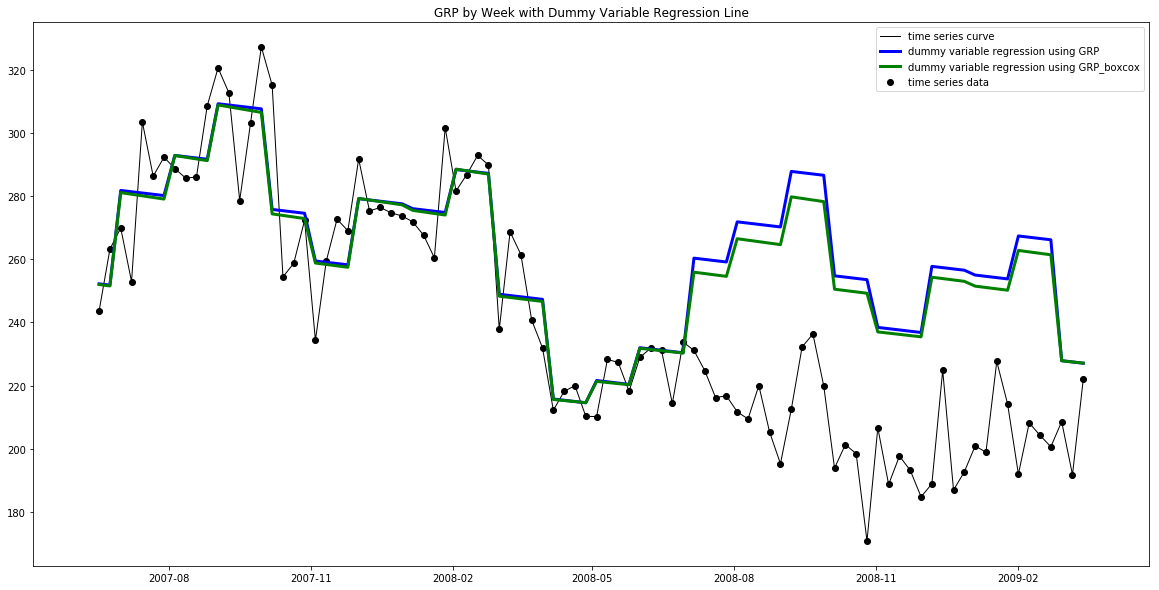

In [71]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with Dummy Variable Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([dummy_var_reg_train_pred, dummy_var_reg_test_pred]), color='blue',
         linewidth=3, label='dummy variable regression using GRP')
plt.plot(ts_df.index.values, np.concatenate([dummy_var_reg_trnsf_train_pred, dummy_var_reg_trnsf_test_pred]), color='green',
         linewidth=3, label='dummy variable regression using GRP_boxcox')
plt.legend()
plt.show()

The dummy variable regression model generalises poorly to the test data. it fails to model the seasonality pattern, even using the Box-Cox transformation.

In [73]:
residuals = train_ts_dummy_df['GRP'].values - dummy_var_reg_trnsf_train_pred
dummy_var_reg_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=4)),
        ('linear', LinearRegression(fit_intercept=False))])
dummy_var_reg_res.fit(train_ts_dummy_df['week'].values.reshape(-1, 1), residuals)
dummy_var_reg_res_pred = dummy_var_reg_res.predict(train_ts_dummy_df['week'].values.reshape(-1, 1))

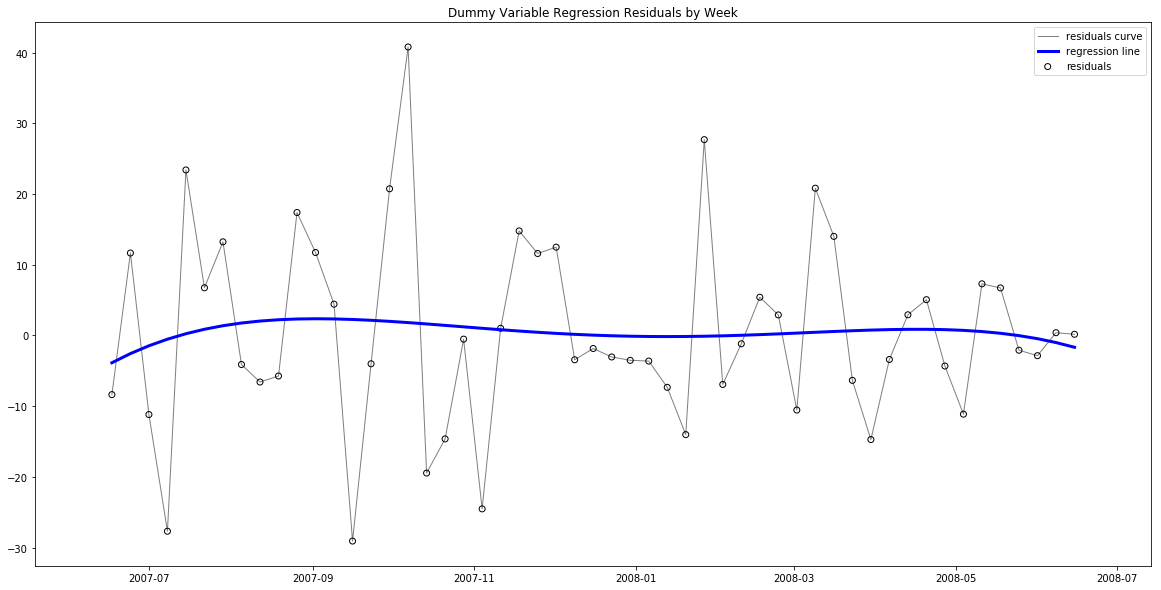

In [74]:
plt.figure(figsize=(20, 10))
plt.title('Dummy Variable Regression Residuals by Week')
plt.scatter(train_ts_dummy_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_dummy_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_dummy_df.index.values, dummy_var_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

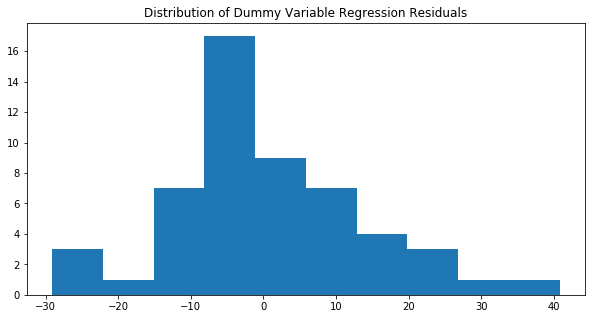

In [75]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of Dummy Variable Regression Residuals')
plt.hist(residuals)
plt.show()

In [76]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,0.001116,0.973345
1,2,7.169435,0.027744
2,3,10.289736,0.016257
3,4,10.365983,0.034694
4,5,10.591154,0.060117
5,6,12.554411,0.050684
6,7,12.890715,0.074816
7,8,13.379054,0.099456
8,9,13.959104,0.123787
9,10,15.053429,0.130126


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


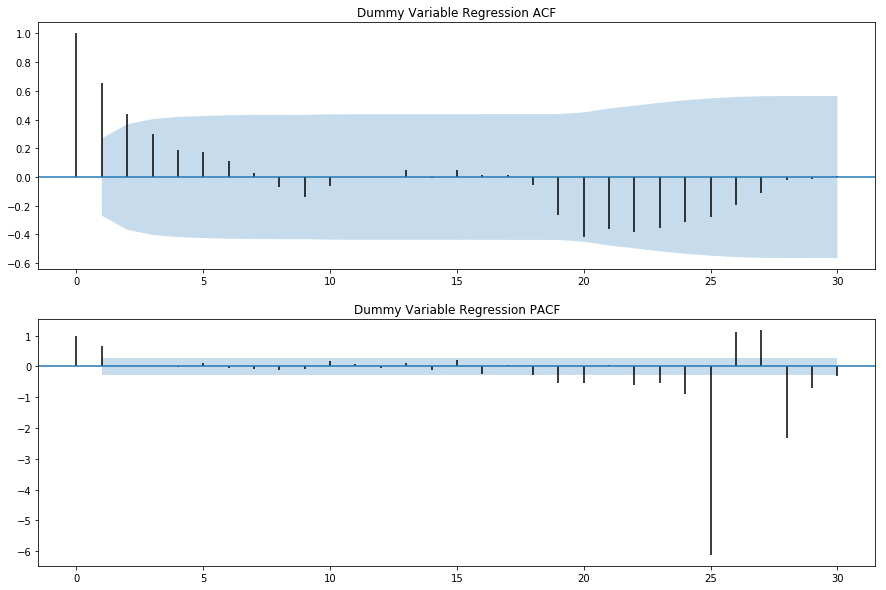

In [114]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, title='Dummy Variable Regression ACF', lags=30, marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, title='Dummy Variable Regression PACF', lags=30, marker=None)
plt.show()

The linear regression model using time and dummy variables for seasonality generalises poorly and the residuals exhibits some autocorrelation at lag 2 and maybe more. 

## 20 Week Seasonality Dummy Variable Model

In [79]:
ts_df['season'] = ts_df['week']%20
ts_df[18:22]

,week,GRPRatingsDate,GRP,GRP_boxcox,month,season
weekly_date,,,,,,
2007-10-21,18,21-Oct-2007 (43),258.73,1.686286,10,18
2007-10-28,19,28-Oct-2007 (44),272.35,1.688444,10,19
2007-11-04,20,04-Nov-2007 (45),234.26,1.681924,11,0
2007-11-11,21,11-Nov-2007 (46),259.35,1.686388,11,1


In [80]:
pd.get_dummies(ts_df['season']).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
weekly_date,,,,,,,,,,,,,,,,,,,,
2007-06-17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-06-24,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-07-01,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-07-08,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-07-15,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
ts_season_df = pd.concat([pd.get_dummies(ts_df['season']), ts_df.drop(labels='season', axis=1)], axis=1)
ts_season_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,week,GRPRatingsDate,GRP,GRP_boxcox,month
weekly_date,,,,,,,,,,,,,,,,,,,,,
2007-06-17,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17-Jun-2007 (25),243.60,1.683670,6
2007-06-24,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,24-Jun-2007 (26),263.19,1.687012,6
2007-07-01,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,2,01-Jul-2007 (27),269.89,1.688067,7
2007-07-08,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,3,08-Jul-2007 (28),252.88,1.685303,7
2007-07-15,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,4,15-Jul-2007 (29),303.46,1.692792,7


In [82]:
# Split into training and test datasets.
train_ts_season_df = ts_season_df.loc['17/6/2007':'17/6/2008']
test_ts_season_df = ts_season_df.loc['18/6/2008':]

In [93]:
# Using GRP
season20_reg = LinearRegression()
season20_reg.fit(train_ts_season_df.iloc[:, :21].values, train_ts_season_df['GRP'])
season20_reg_train_pred = season20_reg.predict(train_ts_season_df.iloc[:, :21].values)

# Using ln GRP
season20_reg_trnsf = LinearRegression()
season20_reg_trnsf.fit(train_ts_season_df.iloc[:, :21].values, train_ts_season_df['GRP_boxcox'])
season20_reg_trnsf_train_pred = inv_boxcox(season20_reg_trnsf.predict(train_ts_season_df.iloc[:, :21].values), BOXCOX_LAMBDA)

### Train Results

In [94]:
# Using GRP
season20_reg_train_mse = mean_squared_error(train_ts_season_df['GRP'].values, season20_reg_train_pred)
season20_reg_train_rmse = np.sqrt(season20_reg_train_mse)
season20_reg_train_mape = np.sum(np.abs(train_ts_season_df['GRP'].values - season20_reg_train_pred) / train_ts_season_df['GRP'].values)\
                          / len(train_ts_season_df['GRP'].values) * 100
season20_reg_r2 = r2_score(train_ts_season_df['GRP'].values, season20_reg_train_pred)

print('mse = %f\nrmse = %f\nmape = %f\nr2      = %f' % (season20_reg_train_mse, season20_reg_train_rmse, season20_reg_train_mape, season20_reg_r2))

mse = 189.038690
rmse = 13.749134
mape = 4.454398
r2      = 0.799317


In [95]:
# Using GRP_boxcox
season20_reg_trnsf_train_mse = mean_squared_error(train_ts_season_df['GRP'].values, season20_reg_trnsf_train_pred)
season20_reg_trnsf_train_rmse = np.sqrt(season20_reg_trnsf_train_mse)
season20_reg_trnsf_train_mape = np.sum(np.abs(train_ts_season_df['GRP'].values - season20_reg_trnsf_train_pred) / train_ts_season_df['GRP'].values)\
                                / len(train_ts_season_df['GRP'].values) * 100
season20_reg_trnsf_r2 = r2_score(train_ts_season_df['GRP'].values, season20_reg_trnsf_train_pred)
print('mse = %f\nrmse = %f\nmape = %f\nr2       = %f' % (season20_reg_trnsf_train_mse, season20_reg_trnsf_train_rmse,
                                                         season20_reg_trnsf_train_mape, season20_reg_trnsf_r2))

mse = 197.129351
rmse = 14.040276
mape = 4.572934
r2       = 0.790728


### Test Results

In [99]:
# Using GRP
season20_reg_test_pred = season20_reg.predict(test_ts_season_df.iloc[:, :21].values)
season20_reg_test_mse = mean_squared_error(test_ts_season_df['GRP'].values, season20_reg_test_pred)
season20_reg_test_rmse = np.sqrt(season20_reg_test_mse)
season20_reg_test_mape = np.sum(np.abs(test_ts_season_df['GRP'].values - season20_reg_test_pred) / test_ts_season_df['GRP'].values)\
                          / len(test_ts_season_df['GRP'].values) * 100
print('mse = %f\nrmse = %f\nmape = %f' % (season20_reg_test_mse, season20_reg_test_rmse, season20_reg_test_mape))

mse = 814.333892
rmse = 28.536536
mape = 11.955567


In [101]:
# Using ln GRP
season20_reg_trnsf_test_pred = inv_boxcox(season20_reg_trnsf.predict(test_ts_season_df.iloc[:, :21].values), BOXCOX_LAMBDA)
season20_reg_trnsf_test_mse = mean_squared_error(test_ts_season_df['GRP'].values, season20_reg_trnsf_test_pred)
season20_reg_trnsf_test_rmse = np.sqrt(season20_reg_trnsf_test_mse)
season20_reg_trnsf_test_mape = np.sum(np.abs(test_ts_season_df['GRP'].values - season20_reg_trnsf_test_pred) / test_ts_season_df['GRP'].values)\
                          / len(test_ts_season_df['GRP'].values) * 100
print('mse = %f\nrmse = %f\nrmse = %f' % (season20_reg_trnsf_test_mse, season20_reg_trnsf_test_rmse, season20_reg_trnsf_test_mape))

mse = 460.577901
rmse = 21.461079
rmse = 8.786936


In [102]:
results_list.append([season20_reg_train_mse, season20_reg_train_rmse, season20_reg_train_mape, season20_reg_r2,
                     season20_reg_test_mse, season20_reg_test_rmse, season20_reg_test_mape])
results_list.append([season20_reg_trnsf_train_mse, season20_reg_trnsf_train_rmse, season20_reg_trnsf_train_mape, season20_reg_trnsf_r2,
                     season20_reg_trnsf_test_mse, season20_reg_trnsf_test_rmse, season20_reg_trnsf_test_mape])
results_list

[[583.97119424801372,
  24.165495944590372,
  7.1807174125844586,
  0.38005858772868173,
  237.06866921261994,
  15.397034429156152,
  6.3161360879461865],
 [392.07867460902827,
  19.800976607456217,
  5.920484423354174,
  0.58377089546071503,
  5331.7905399494612,
  73.019110785803605,
  26.619380477277272],
 [189.0386904807591,
  13.749134172040039,
  4.4543980644759538,
  -2.4692968331997429,
  814.33389202074329,
  28.536536090085342,
  11.955567175570996],
 [197.12935123621418,
  14.040276038462142,
  4.5729340840807167,
  0.7907282934342732,
  460.57790137433489,
  21.461078756072233,
  8.7869360662880904]]

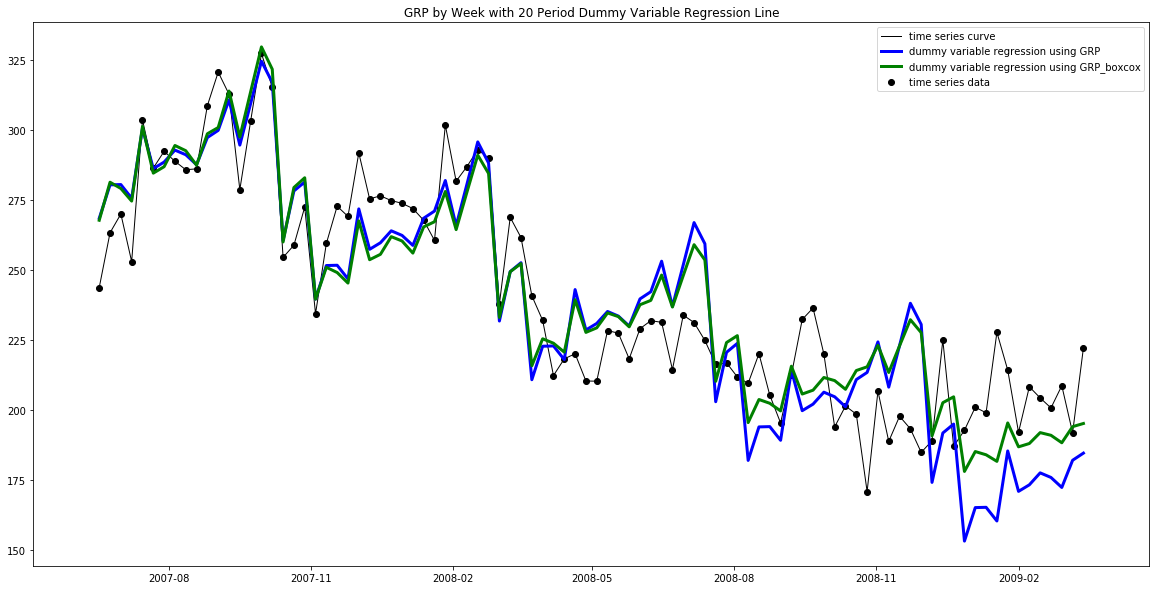

In [104]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with 20 Period Dummy Variable Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([season20_reg_train_pred, season20_reg_test_pred]), color='blue',
         linewidth=3, label='dummy variable regression using GRP')
plt.plot(ts_df.index.values, np.concatenate([season20_reg_trnsf_train_pred, season20_reg_trnsf_test_pred]), color='green',
         linewidth=3, label='dummy variable regression using GRP_boxcox')
plt.legend()
plt.show()

## Conclusion

In [71]:
results_df = pd.DataFrame(results_list, index=['Linear Regression', 'Polynomial Regression', 'Dummy Variable Regression', 'Dummy Variable Regression with Box_Cox',
                                               '20 Period Dummy Variable Regression', '20 Period Dummy Variable Regression with Box_Cox'],
                          columns=['train mse', 'train rmse', 'train r2', 'test mse', 'test rmse'])
results_df

,train mse,train rmse,train r2,test mse,test rmse
Linear Regression,552.069285,23.496155,0.413926,277.590290,16.661041
Polynomial Regression,392.078675,19.800977,0.583771,5331.790540,73.019111
Dummy Variable Regression,178.852264,13.373566,0.810131,2819.982555,53.103508
Dummy Variable Regression with Box_Cox,179.350545,13.392182,0.809602,2551.448216,50.511862
20 Period Dummy Variable Regression,189.038690,13.749134,0.799317,814.333892,28.536536
20 Period Dummy Variable Regression with Box_Cox,191.720456,13.846316,0.796470,538.501637,23.205638


In [72]:
season20_reg.coef_

array([-36.53516243, -23.13087147, -21.58658051, -25.03562288,
         1.42866808, -11.57037429,  -7.79275   ,  -2.07845904,
        -2.28083475,  -4.40987712,   6.74108051,  10.7387048 ,
        23.0863291 ,   8.36437712,  24.65533475,  41.20129237,
        35.08725   , -19.89679237,  -0.81083475,   3.82512288,  -1.44095763])

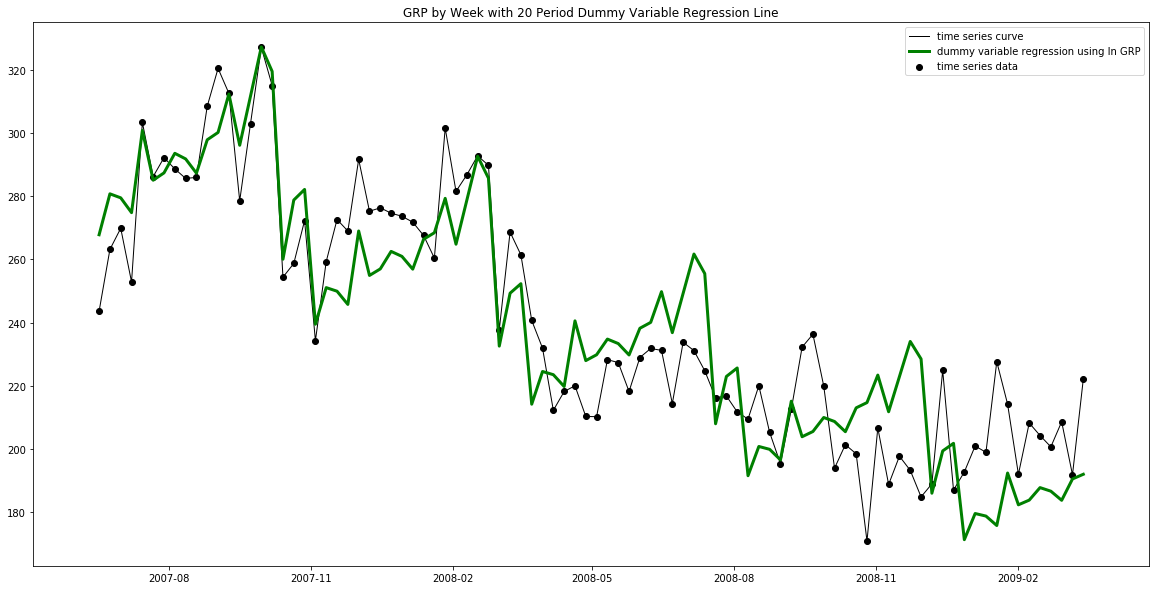

In [73]:
plt.figure(figsize=(20, 10))
plt.title('GRP by Week with 20 Period Dummy Variable Regression Line')
plt.scatter(ts_df.index.values, ts_df['GRP'].values, color='black', label='time series data')
plt.plot(ts_df.index.values, ts_df['GRP'].values, color='black', linewidth=1, label='time series curve')
plt.plot(ts_df.index.values, np.concatenate([season20_reg_trnsf_train_pred, season20_reg_trnsf_test_pred]), color='green',
         linewidth=3, label='dummy variable regression using ln GRP')
plt.legend()
plt.show()

### Analysis of Residuals

In [105]:
residuals = train_ts_season_df['GRP'].values - season20_reg_trnsf_train_pred
season20_reg_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=4)),
        ('linear', LinearRegression(fit_intercept=False))])
season20_reg_res.fit(train_ts_season_df['week'].values.reshape(-1, 1), residuals)
season20_reg_res_pred = season20_reg_res.predict(train_ts_season_df['week'].values.reshape(-1, 1))

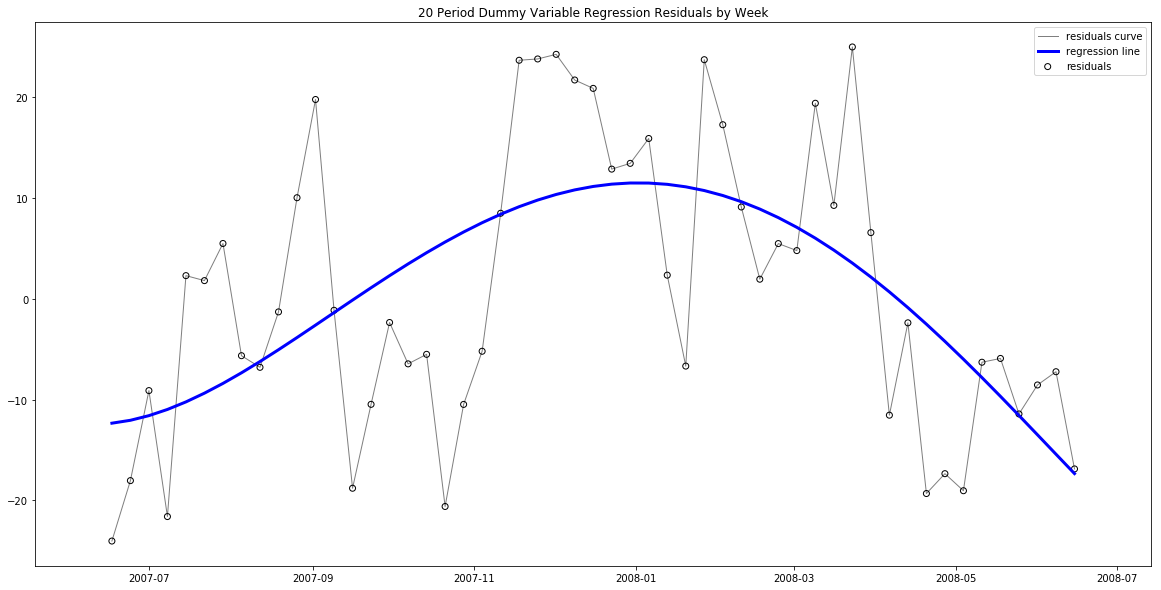

In [107]:
plt.figure(figsize=(20, 10))
plt.title('20 Period Dummy Variable Regression Residuals by Week')
plt.scatter(train_ts_season_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_season_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_season_df.index.values, season20_reg_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

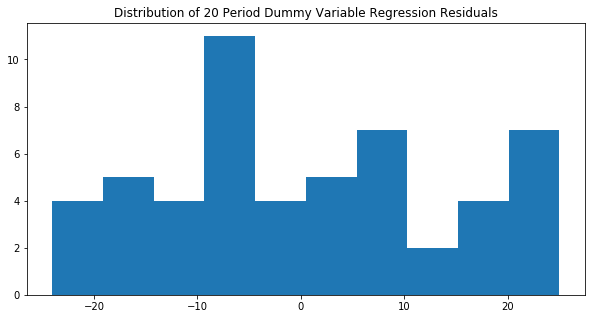

In [108]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of 20 Period Dummy Variable Regression Residuals')
plt.hist(residuals)
plt.show()

In [109]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,24.120307,9.050088e-07
1,2,35.018070,2.488414e-08
2,3,40.167830,9.817031e-09
3,4,42.346648,1.413751e-08
4,5,44.146147,2.163265e-08
5,6,44.939975,4.810519e-08
6,7,44.991286,1.372940e-07
7,8,45.302092,3.225253e-07
8,9,46.526392,4.807804e-07
9,10,46.813560,1.020928e-06


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


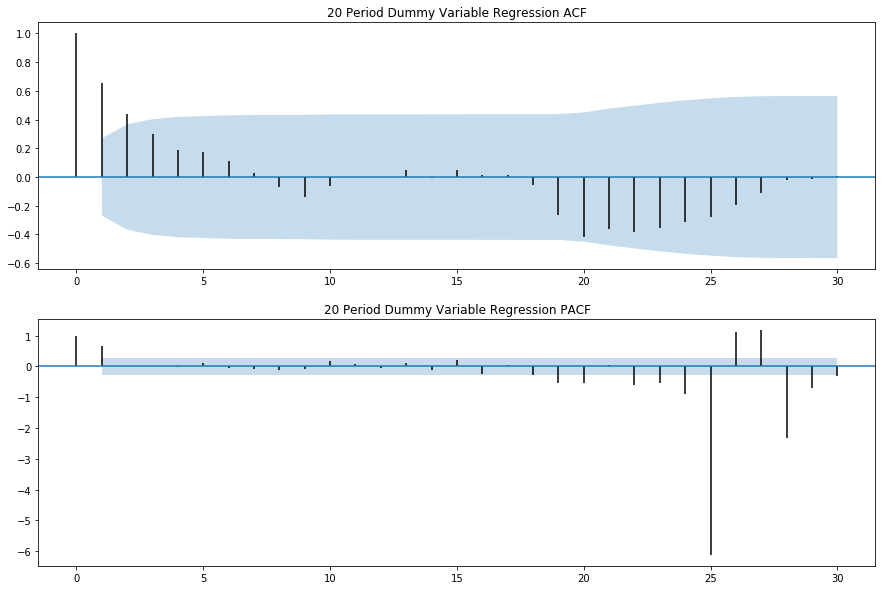

In [115]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, lags=30, title='20 Period Dummy Variable Regression ACF', marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, lags=30, title='20 Period Dummy Variable Regression PACF', marker=None)
plt.show()